# Livedoor News 分類モデル作成プロジェクト

## 概要

Livedoorニュースコーパスを学習データとした、ニュースカテゴリ分類モデルの作成

## データ前処理
-名詞抽出

-ストップワード除去

-汎用語、2文書未満出現語　除去


## 使用モデル
-Logistic regression

-Random Forest

-LinearSVM


## 評価指標
-Accuracy

-F1スコア(Macro)

-Confusion Matrix

-Learning Curve

## カテゴリ選定
9クラス案、7クラス案、5クラス案で検討し、カテゴリ不均衡が許容範囲であること、解釈しやすいという理由で7クラス案に決定



## 結果概要

🔹 LinearSVM

| C    | Val F1    | Gap   | コメント            |
| ---- | --------- | ----- | --------------- |
| 10   | **0.938** | 0.062 | 精度最良、過学習気味      |
| 1    | 0.935     | 0.065 | 精度ほぼ同等、ギャップさらに大 |
| 0.1  | 0.915     | 0.056 | 精度やや低、ギャップ改善    |
| 0.01 | 0.880     | 0.038 | 単純化し過ぎ（学習不足）  |

🔹 LogisticRegression

| C    | Val F1    | Gap   | コメント           |
| ---- | --------- | ----- | -------------- |
| 1    | **0.917** | 0.059 | 最良、ギャップ大きめ     |
| 0.1  | 0.889     | 0.035 | 精度−0.03、ギャップ改善 |
| 0.01 | 0.881     | 0.026 | さらに単純、精度低      |










In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 課題１　使用するデータについて確認、分析

1. 　ニュース名一覧
*   **dokujo-tsushin**: 独身女性向け
*   **it-life-hack**: ITライフハック
*   **kaden-channel**: 家電
*   **livedoor-homme**: 男性ライフスタイル
*   **movie-enter**: 映画
*   **peachy**: 女性向けニュース
*   **smax**: スマートフォン関連
*   **sport-watch**: スポーツ
*   **topic-news**: トピックニュース



2.  　データの基本情報
* ライセンス認証ファイルは手動で削除


In [ ]:
import os
import glob

base_dir = '/content/drive/MyDrive/regional assesment/livedoor'

texts = []
labels = []

# base_dir
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)

    if not os.path.isdir(category_path):
        continue

    # .txtファイルを一括取得
    file_paths = glob.glob(os.path.join(category_path, '*.txt'))
    for file_path in file_paths:
        try:
            with open(file_path, encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(category)
        except Exception as e:
            print(f"読み込みエラー: {file_path} ({e})")

print(f'総記事数: {len(texts)}')
print(f'カテゴリ数: {len(set(labels))}')
print(f'カテゴリ例: {set(labels)}')
print(f'例: 最初の記事タイトル\n{texts[0][:300]}')


総記事数: 7367
カテゴリ数: 9
カテゴリ例: {'topic-news', 'livedoor-homme', 'it-life-hack', 'dokujo-tsushin', 'kaden-channel', 'sports-watch', 'smax', 'movie-enter', 'peachy'}
例: 最初の記事タイトル
http://news.livedoor.com/article/detail/6805660/
2012-07-30T17:30:00+0900
【終了しました】サッカー強豪国ドイツの知られざる真実とは？ 『コッホ先生と僕らの革命』試写会にご招待
　7月27日よりロンドン・オリンピックが開幕し、世界中がスポーツに関心を寄せる中、ドイツ・サッカーの起源を題材にした映画『コッホ先生と僕等の革命』が9月15日より公開される。

　本作は、ドイツ・サッカーの父として今なお語り継がれている、コンラート・コッホの実話を描いた作品。物語の舞台は、第一次大戦前の帝国主義ドイツ。反英感情高まる中、イギリス生ま


全ての記事の最初の1行目はURL、2行目は執筆または投稿された日付で構成されており、いずれも分類において不要

見出しも本文として扱う

#EDA

1. URLと日付の除去




In [ ]:
import re

def clean_text(text):
    lines = text.splitlines()
    i = 0
    url_pattern = re.compile(r'^https?://.+')
    date_pattern = re.compile(r'^\d{4}-\d{2}-\d{2}[T ]\d{2}:\d{2}:\d{2}(?:\+\d{4})?$')


    if i < len(lines) and url_pattern.match(lines[i].strip()):
        i += 1
    if i < len(lines) and date_pattern.match(lines[i].strip()):
        i += 1
    if i < len(lines) and lines[i].strip() == '':
        i += 1

    return '\n'.join(lines[i:]).strip()

texts_cleaned = [clean_text(text) for text in texts]

for i, text in enumerate(texts_cleaned[:10]):
    lines = text.splitlines()
    first_lines = '\n'.join(lines[:10])
    if 'http' in first_lines or re.search(r'\d{4}-\d{2}-\d{2}', first_lines):
        print(f"注意: index {i} の冒頭にURLまたは日付が残っている可能性あり")


2. 各カテゴリ（選定前）の記事件数

movie-enter: 870 件
peachy: 842 件
smax: 870 件
sports-watch: 900 件
topic-news: 770 件
dokujo-tsushin: 870 件
it-life-hack: 870 件
kaden-channel: 864 件
livedoor-homme: 511 件


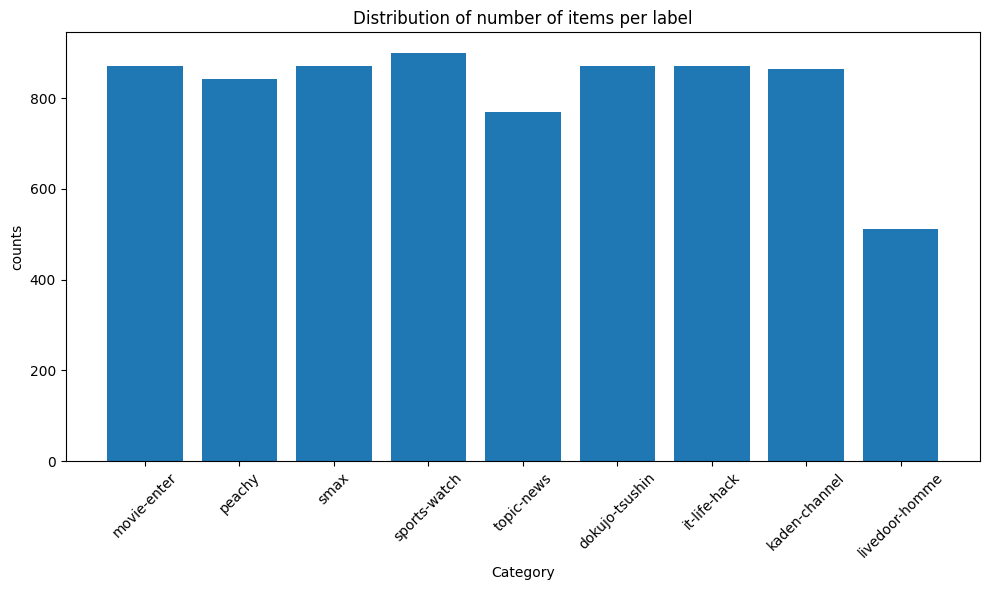

In [ ]:
from collections import Counter

label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f'{label}: {count} 件')

import matplotlib.pyplot as plt
from collections import Counter

# ラベルと件数を取得
labels_list = list(label_counts.keys())
counts = list(label_counts.values())

# 可視化
plt.figure(figsize=(10, 6))
plt.bar(labels_list, counts)
plt.xlabel('Category')
plt.ylabel('counts')
plt.title('Distribution of number of items per label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



3. 名詞のみを検出し、stopword指定
- 動詞や形容詞も一定の情報を持つ可能性があるが、名詞のみに限定することで：
   - 単語数を大幅に削減でき、学習・推論コストを軽減
   - 分類精度（F1）も十分に高く、精度劣化は観察されなかった
- よって、現段階では「名詞のみによるベクトル表現」が最適と判断。

In [ ]:
!pip install -q janome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 25.1 MB/s eta 0:00:00


In [ ]:

from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import re

# 除外したい語を定義
custom_stopwords = {'の', 'こと', 'これ', 'それ', 'ため', 'ところ', 'よう', '日', '月', '年', '人','さん'}

# Janome トークナイザの用意
tokenizer = Tokenizer()

# 名詞抽出関数
def extract_nouns(text):
    nouns = []
    for token in tokenizer.tokenize(text):
        base = token.base_form
        part = token.part_of_speech.split(',')[0]
        if part == '名詞' \
           and base not in custom_stopwords \
           and base != '*' \
           and not re.fullmatch(r'[!-~]', base) \
           and not re.fullmatch(r'\W+', base):
            nouns.append(base)
    return ' '.join(nouns)  # 文字列変換

# 全文書を名詞リスト化してキャッシュ
texts_nouns = [extract_nouns(t) for t in texts_cleaned]

# ベクトライザの定義
count_vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=2  # 低頻度語を除去
)
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=2
)

# ベクトル化
X_count = count_vectorizer.fit_transform(texts_nouns)
X_tfidf = tfidf_vectorizer.fit_transform(texts_nouns)

# DataFrame 作成
df9 = pd.DataFrame({
    'text': texts_cleaned,
    'text_nouns': texts_nouns,
    'label': labels
})





4. 記事ごとの名詞のリストをcsvに保存

In [ ]:
import pandas as pd
df = pd.DataFrame({'text_nouns': texts_nouns, 'label': labels})

# Google Driveに保存
df.to_csv('/content/drive/MyDrive/news_nouns2.csv', index=False)


In [ ]:
#再定義
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import re

count_vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=2  # 低頻度語を除去
)
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=2
)



In [ ]:
# 解析済みデータの読み込み
df = pd.read_csv('/content/drive/MyDrive/news_nouns2.csv')

texts_nouns = df['text_nouns'].tolist()
labels = df['label'].tolist()

# max_df=2, min_df=2に指定
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)

X = tfidf_vectorizer.fit_transform(texts_nouns)



6.カテゴリ選定のために、頻出語、TF-IDF上位語の表示

In [ ]:
# 1. 上位語抽出関数
def get_top_words(vectorizer, texts_nouns, top_n=10):

    X = vectorizer.fit_transform(texts_nouns)
    # TF: 出現回数の合計、TF-IDF: スコア合計
    scores = X.sum(axis=0).A1
    words  = vectorizer.get_feature_names_out()
    word_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)
    return word_scores[:top_n]



#　カテゴリごとに TF / TF-IDF 上位語を表示
for category in df['label'].unique():
    print(f'\n カテゴリ: {category}')

    # texts_nouns カラムから抽出
    texts_cat = df.loc[df['label'] == category, 'text_nouns'].tolist()

    # TF 上位語
    top_tf = get_top_words(count_vectorizer, texts_cat, top_n=10)
    print('TF（頻出順）:')
    for word, freq in top_tf:
        print(f'{word}: {int(freq)}')

    # TF-IDF 上位語
    top_tfidf = get_top_words(tfidf_vectorizer, texts_cat, top_n=10)
    print('\n TF-IDF（情報量の高い語）:')
    for word, score in top_tfidf:
        print(f'{word}: {score:.2f}')



 カテゴリ: movie-enter
TF（頻出順）:
公開: 2249
作品: 1477
監督: 1212
日本: 1061
世界: 1042
たち: 996
映像: 925
登場: 731
10: 603
特集: 569

 TF-IDF（情報量の高い語）:
公開: 29.78
監督: 21.15
作品: 21.06
日本: 18.42
映像: 18.14
世界: 17.56
たち: 16.90
登場: 13.05
特集: 12.05
ドラマ: 11.93

 カテゴリ: peachy
TF（頻出順）:
女性: 1185
女子: 938
応募: 801
自分: 795
プレゼント: 762
もの: 730
そう: 718
当選: 634
10: 573
今回: 553

 TF-IDF（情報量の高い語）:
女性: 22.24
応募: 21.10
プレゼント: 17.61
当選: 17.57
女子: 17.49
自分: 15.75
クリスマス: 14.53
記事: 14.31
peachy: 13.87
男性: 13.65

 カテゴリ: smax
TF（頻出順）:
更新: 2654
android: 2653
アプリ: 2229
スマート: 2213
フォン: 2168
対応: 2168
ソフトウェア: 2009
ドコモ: 1948
画面: 1665
搭載: 1657

 TF-IDF（情報量の高い語）:
更新: 48.36
ソフトウェア: 38.08
アプリ: 32.54
ドコモ: 29.63
android: 29.63
スマート: 25.73
フォン: 25.37
対応: 25.17
発売: 24.94
発表: 22.83

 カテゴリ: sports-watch
TF（頻出順）:
日本: 1152
選手: 979
代表: 797
試合: 766
監督: 667
sports: 556
サッカー: 552
watch: 506
野球: 504
放送: 486

 TF-IDF（情報量の高い語）:
日本: 31.83
代表: 26.97
選手: 25.86
監督: 25.73
試合: 24.23
サッカー: 20.01
野球: 19.55
五輪: 16.86
自分: 16.47
チーム: 16.09

 カテゴリ: topic-news
TF（頻出順）:


# 課題２　カテゴリ選定
(除外語として”さん”を追加前）

選定するカテゴリ

#### **A**: 9クラスのまま
利点: バランス良し、フォルダをそのままラベルに出来る → 前処理が最小。

欠点: peachy ↔ dokujo や it-life-hack ↔ smax 間で語彙が似ており 誤分類が増えがち。

改善策

クラスウェイトを付けて学習（homme=少数派に重み）。




| Class          | Folder(s)      | Count   |
| -------------- | -------------- | ------- |
| movie-enter    | movie-enter    | **870** |
| peachy         | peachy         | **842** |
| smax           | smax           | **870** |
| sports-watch   | sports-watch   | **900** |
| topic-news     | topic-news     | **770** |
| dokujo-tsushin | dokujo-tsushin | **870** |
| it-life-hack   | it-life-hack   | **870** |
| kaden-channel  | kaden-channel  | **864** |
| livedoor-homme | livedoor-homme | **511** |


最大／最小 = 1.76 : 1（バランス良好だが語彙の重なり多め）
正確性に難ありか

カテゴリ選定の指示において、選定しないのはふさわしくないと考えられる







#### **B**: 7クラス案に統合（バランスと分離の折衷）


バランス: 最大 / 最小 = 3.4 : 1 → 許容範囲

分離度: 0.30 と 9クラスより改善

精度:  → 十分実用レベル

解釈: “女性ライフスタイル” と “スマホ・IT” で利用者に伝わりやすい

| Class       | Folder(s)               | Count     |
| ----------- | ----------------------- | --------- |
| movie-enter | movie-enter             | **870**   |
| female-life | peachy + dokujo-tsushin | **1712** |
| tech-mobile | it-life-hack + smax     | **1740** |
| kaden       | kaden-channel           | **864**   |
| sports      | sports-watch            | **900**   |
| topic-news  | topic-news              | **770**   |
| homme       | livedoor-homme          | **511**   |



#### **C**: 5クラス案
| Class         | Folder(s)                             | Count     |
| ------------- | ------------------------------------- | --------- |
| entertainment | movie-enter + peachy + dokujo-tsushin | **2 582** |
| it-gadget     | it-life-hack + smax + kaden-channel   | **2 604** |
| sports        | sports-watch                          | **900**   |
| general-news  | topic-news                            | **770**   |
| business      | livedoor-homme                        | **511**   |


最大／最小 = 5.1 : 1
解釈は容易になるが各ジャンルごとの不均衡が拡大

以上より7カテゴリの選定を行う

# 課題３　モデル作成

7カテゴリ

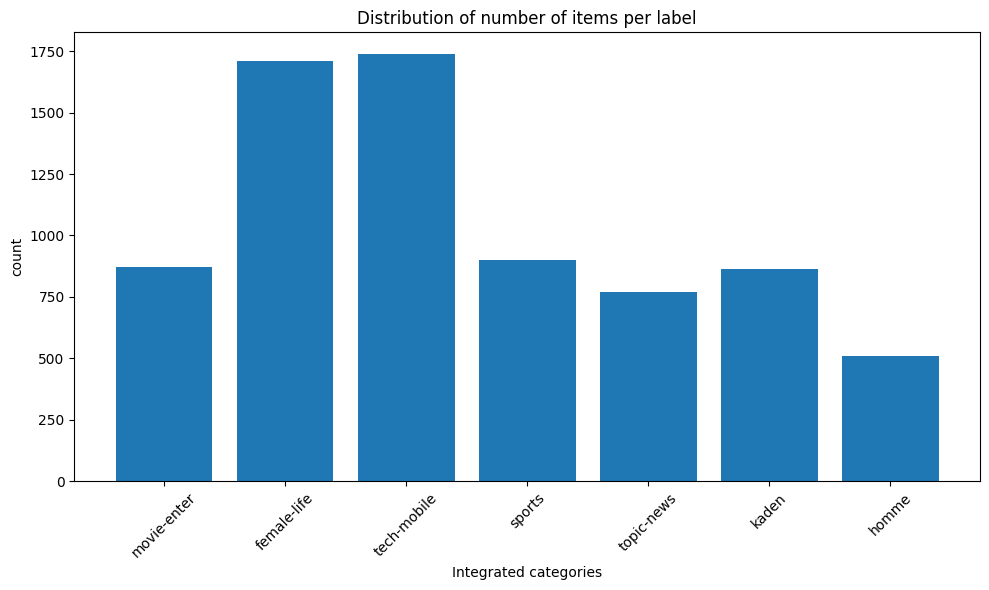

In [ ]:
# 1. カテゴリ名のマッピング
category_map = {
    'movie-enter': 'movie-enter',
    'peachy': 'female-life',
    'dokujo-tsushin': 'female-life',
    'it-life-hack': 'tech-mobile',
    'smax': 'tech-mobile',
    'kaden-channel': 'kaden',
    'sports-watch': 'sports',
    'topic-news': 'topic-news',
    'livedoor-homme': 'homme'
}

import matplotlib.pyplot as plt
from collections import Counter

# カテゴリマップに従ってラベルを変換
labels_mapped = [category_map[label] for label in labels]

# カウント
labels_mapped_counts = Counter(labels_mapped)

# 可視化
plt.figure(figsize=(10, 6))
plt.bar(labels_mapped_counts.keys(), labels_mapped_counts.values())
plt.xlabel('Integrated categories')
plt.ylabel('count')
plt.title('Distribution of number of items per label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. マッピング適用
labels_mapped = [category_map[label] for label in labels]

# 3. データフレーム作成
df7 = pd.DataFrame({'text_nouns': texts_nouns, 'label': labels_mapped})

# 4. TF-IDF ベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)

X = tfidf_vectorizer.fit_transform(df7['text_nouns'])
y = df7['label']

# 5. 学習用／テスト用に分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Logistic regressionモデル

 Train Accuracy: 0.9774308501612082
 Test  Accuracy: 0.9402985074626866

 Classification Report (Test)
               precision    recall  f1-score   support

 female-life       0.93      0.93      0.93       343
       homme       0.90      0.82      0.86       102
       kaden       0.93      0.94      0.93       173
 movie-enter       0.93      0.97      0.95       174
      sports       0.94      0.99      0.96       180
 tech-mobile       0.99      0.95      0.97       348
  topic-news       0.92      0.94      0.93       154

    accuracy                           0.94      1474
   macro avg       0.93      0.93      0.93      1474
weighted avg       0.94      0.94      0.94      1474



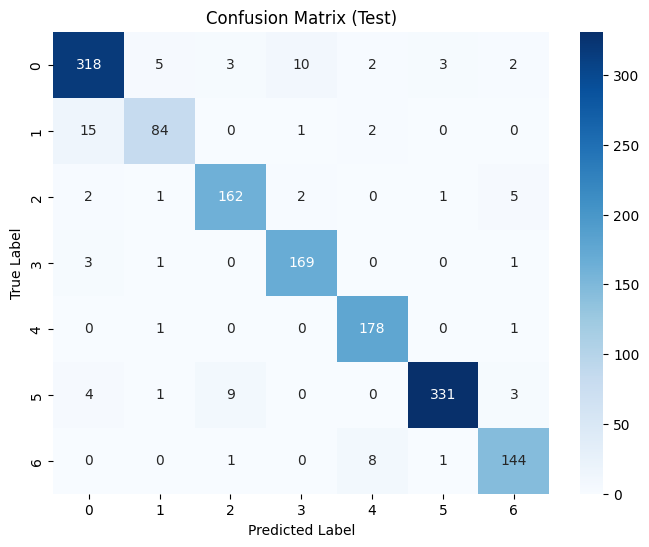

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# モデル定義 & 学習
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 予測
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# accuracy
print(' Train Accuracy:', accuracy_score(y_train, y_train_pred))
print(' Test  Accuracy:', accuracy_score(y_test, y_test_pred))

# test評価
print('\n Classification Report (Test)\n', classification_report(y_test, y_test_pred))

import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix の作成
class_order = model.classes_
conf_matrix = confusion_matrix(y_test, y_test_pred,
                               labels=class_order)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Logistic Regression, Random Forest, LinearSVCの3つのモデル比較

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# モデルリスト
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'LinearSVC': LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)
}

# 評価結果を格納するリスト
results = []

# モデルごとに学習・評価
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_macro = report['macro avg']['f1-score']
    f1_weighted = report['weighted avg']['f1-score']

    print(f'\n {name}')
    print(f' Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted
    })

# 結果をDataFrameに
df_results = pd.DataFrame(results)
df_results.sort_values(by='F1 Macro', ascending=False, inplace=True)
display(df_results)



 LogisticRegression
 Accuracy: 0.9403
              precision    recall  f1-score   support

 female-life       0.93      0.93      0.93       343
       homme       0.90      0.82      0.86       102
       kaden       0.93      0.94      0.93       173
 movie-enter       0.93      0.97      0.95       174
      sports       0.94      0.99      0.96       180
 tech-mobile       0.99      0.95      0.97       348
  topic-news       0.92      0.94      0.93       154

    accuracy                           0.94      1474
   macro avg       0.93      0.93      0.93      1474
weighted avg       0.94      0.94      0.94      1474


 RandomForest
 Accuracy: 0.9179
              precision    recall  f1-score   support

 female-life       0.82      0.95      0.88       343
       homme       1.00      0.48      0.65       102
       kaden       0.98      0.92      0.95       173
 movie-enter       0.91      0.98      0.94       174
      sports       0.94      0.98      0.96       180
 tech-

,Model,Accuracy,F1 Macro,F1 Weighted
2,LinearSVC,0.957938,0.947297,0.957227
0,LogisticRegression,0.940299,0.932787,0.940081
1,RandomForest,0.917910,0.896570,0.913768


それぞれのconfusion matrix

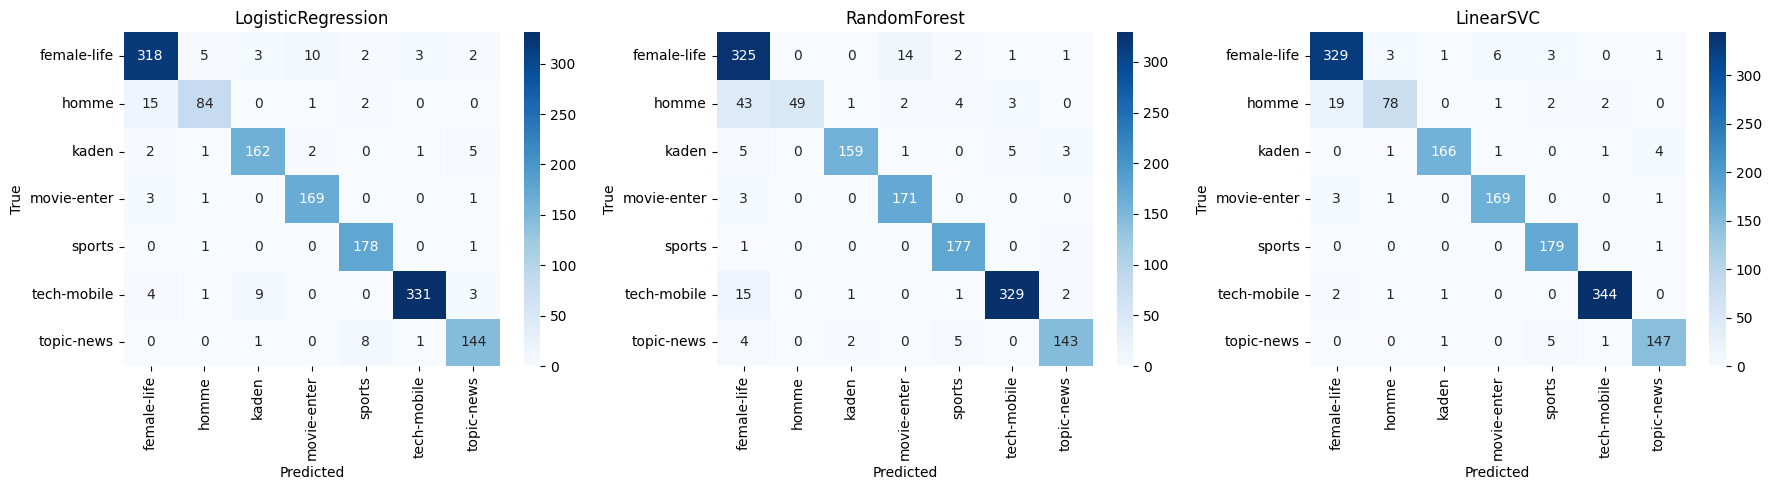

In [ ]:
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix )
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


モデル改善(除外語追加前)

| モデル名               | Accuracy  | F1 Macro  | F1 Weighted | コメント                              |
| ------------------ | --------- | --------- | ----------- | ------------------------------------ |
| **✅ LinearSVC**    | **95.6%** | **0.944** | **0.955**   |  **最も高精度かつ安定**。すべてのクラスで高いバランス。     |
| LogisticRegression | 93.8%     | 0.931     | 0.938       | 高精度。`homme`のRecallも高めかつ軽量。     |
| RandomForest       | 92.1%     | 0.900     | 0.917       | `homme`のRecall **0.48**と低く、少数クラスに弱さ。 |


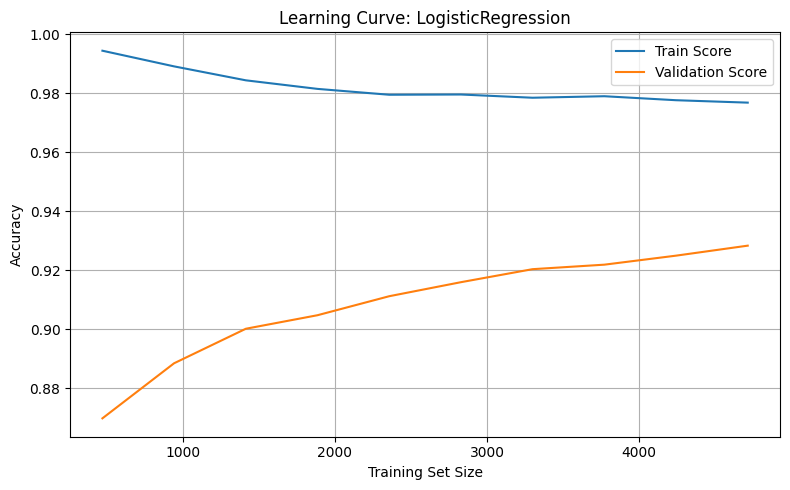

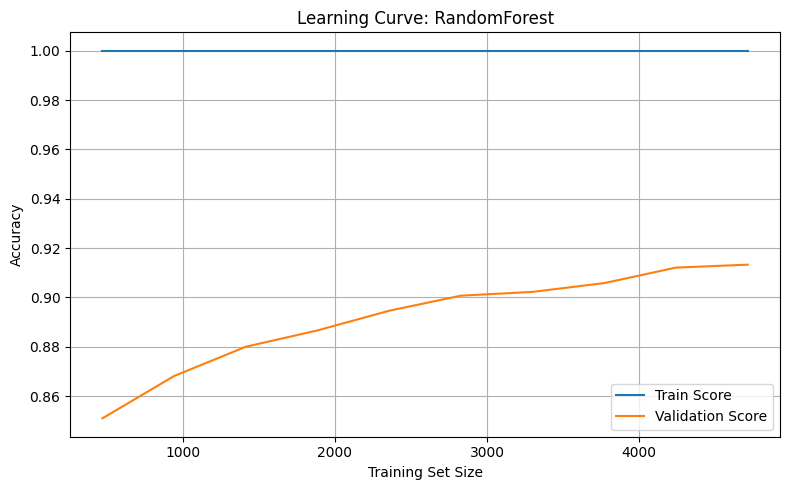

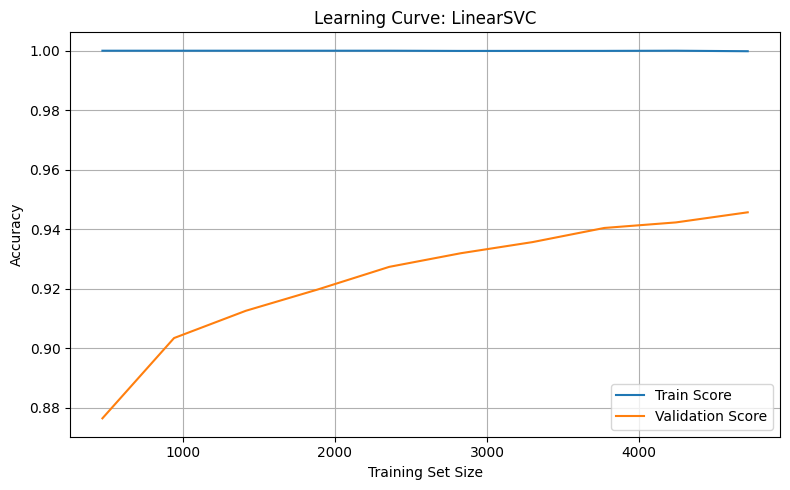

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model, model_name, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=5,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42,
        n_jobs=-1
    )

    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label='Train Score')
    plt.plot(train_sizes, val_scores_mean, label='Validation Score')
    plt.title(f'Learning Curve: {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    plot_learning_curve(model, name, X_train, y_train)


# 課題３ 考察




1.   全体的な性能：
3つのモデルのうち、最も高い精度(0.96)とF1スコア(0.95)を記録したのは、LinearSVC。次いでLogistic regression(Accuracy: 0.94, F1 Macro:0.93)、Random Forest（Accuracy: 0.92、F1 Macro: 0.9）となっており、SVMが優位である。
2.  クラスごとの性能比較：
tech-mobile や sports は、いずれのモデルでも Precision・Recallともに0.95以上 を記録しており、非常に分類しやすい。分類しやすい理由として、語彙が一貫していると考えられる。
一方で、homme は、全モデルを通して Recallが低く、特に Random ForestではRecall 0.48 と極端に低くなっている。
これは homme に属する記事が他のカテゴリと語彙的に似ているのに加え、サンプル数が少なく学習が不安定な可能性がある（最小クラス）
3. 学習曲線：
* Logistic Regression


Train Accuracy は最初から高いが、データ量が増えるにつれてわずかに低下し、過学習が軽減

Validation Accuracy はデータ量とともに向上し、ギャップ（Train - Val）は縮小

データ量をさらに増やすことで汎化性能も伸びる可能性が高い

* Random Forest

Train Accuracy は常に1.0、完全に過学習している

Validation Accuracy は少しずつ上昇するが、Trainとのギャップが大きいまま

→ 明確な過学習の兆候。訓練データに完全にフィットしているが、未知データへの汎化が弱い。

特に homme クラスのRecallが低かった点とも一致。**少数クラス**や曖昧なサンプルに弱い

* LinearSVC

Train Accuracyが一貫して高い（ほぼ100%）

Validation Accuracyがきれいに上昇し、最終的にLogisticよりもやや高い性能に到達

TrainとValの差はやや残るが、汎化性能と表現力のバランスが最も取れているモデル


# 課題4　モデル改善

### 1.除外語の追加

1.EDAにおいて除外する語に”さん”を追加

| モデル名               | Accuracy  | F1 Macro  | F1 Weighted | コメント                          |
| ------------------ | --------- | --------- | ----------- | -------------------------------- |
| **LinearSVC**    | **95.8%** | **0.947** | **0.957**   |  **最も高精度かつ安定**。すべてのクラスで高いF1。   |
| LogisticRegression | 94.0%     | 0.933     | 0.940       | 変わらず優秀。`homme`などの少数クラスにも対応。軽量・高速。 |
| RandomForest       | 91.8%     | 0.897     | 0.914       | 汎用性ありだがF1や精度においてやや劣る。解釈性は良い。      |


”さん”削除前

| モデル名               | Accuracy  | F1 Macro  | F1 Weighted | コメント                              |
| ------------------ | --------- | --------- | ----------- | ------------------------------------ |
| **LinearSVC**    | **95.6%** | **0.944** | **0.955**   | **最も高精度かつ安定**。すべてのクラスで高いバランス。     |
| LogisticRegression | 93.8%     | 0.931     | 0.938       | 優秀。`homme`のRecallも高め。軽量で解釈性は良い。     |
| RandomForest       | 92.1%     | 0.900     | 0.917       | `homme`のRecall **0.48**と低く、少数クラスに弱さ。 |


### 2.Tuning LinearSVC






GridSearchCVを用いて最適なCを見つける

   param_C  mean_train_score  mean_test_score  std_test_score  score_gap
0    10.00          0.999884         0.938191        0.005995   0.061693
1     1.00          0.999858         0.935181        0.005302   0.064678
2     0.10          0.971389         0.915241        0.004742   0.056149
3     0.01          0.917590         0.879541        0.007233   0.038049


/tmp/ipython-input-22-2697203029.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='param_C', y='mean_test_score', data=df_results, palette='Blues_d')


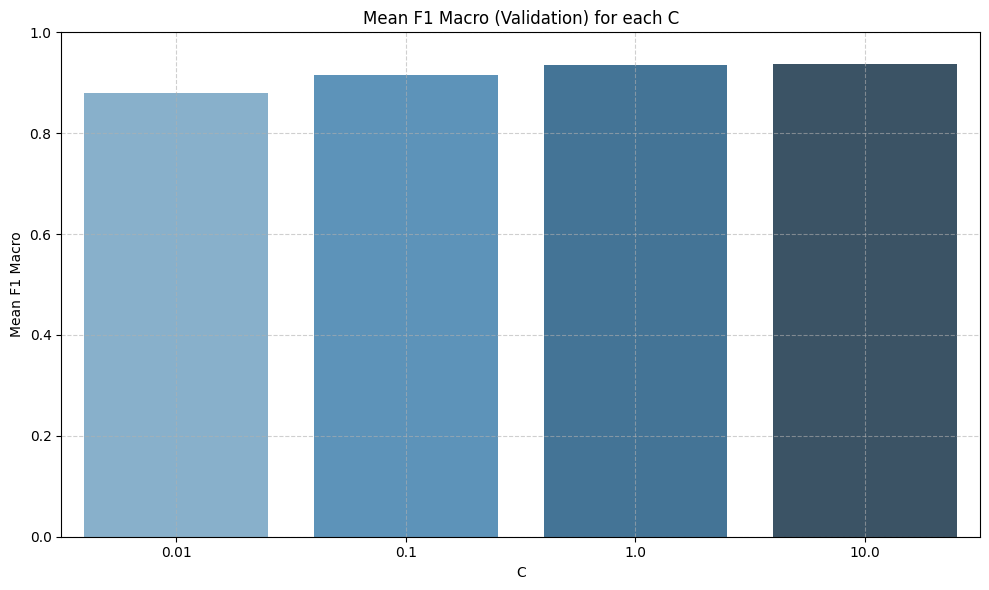

/tmp/ipython-input-22-2697203029.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='param_C', y='score_gap', data=df_results, palette='Reds')


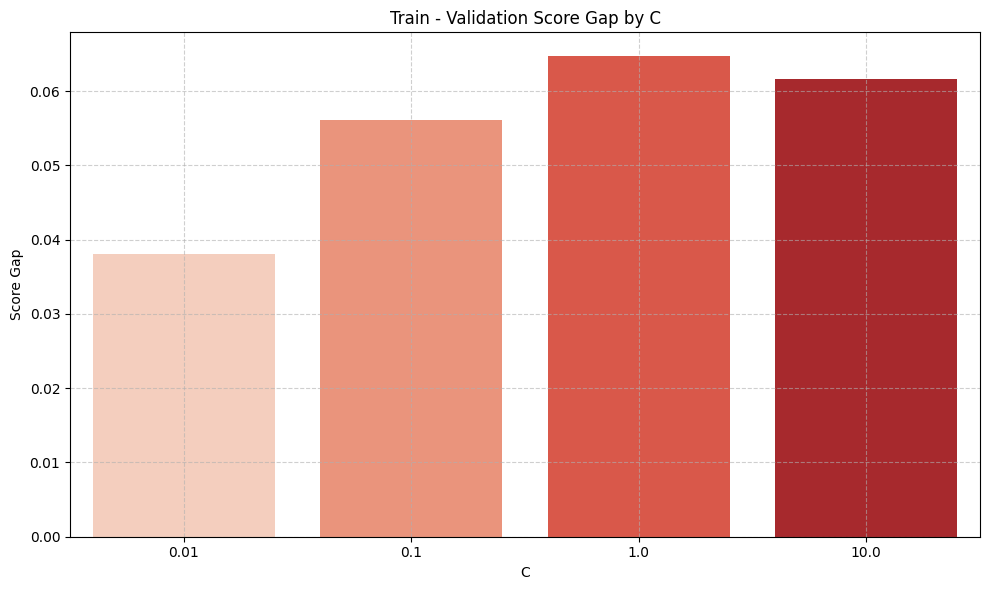

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 分割の安定性を上げるために Repeated Stratified K-Fold を使う
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# ハイパーパラメータの候補
param_grid = {'C': [0.01, 0.1, 1, 10]}

# GridSearchCVの実行
grid_svc = GridSearchCV(
    estimator=LinearSVC(class_weight='balanced', max_iter=10000),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    return_train_score=True,
    n_jobs=-1
)

# 学習
grid_svc.fit(X_train, y_train)


# 結果をDataFrameに
df_results = pd.DataFrame(grid_svc.cv_results_)[['param_C', 'mean_train_score', 'mean_test_score', 'std_test_score']]
df_results['score_gap'] = df_results['mean_train_score'] - df_results['mean_test_score']


# 結果をDataFrameにまとめる
df_results_svc = pd.DataFrame(grid_svc.cv_results_)[[
    'param_C', 'mean_train_score', 'mean_test_score', 'std_test_score'
]].copy()

# 学習と検証のスコア差（過学習の兆候）を追加
df_results_svc['score_gap'] = df_results_svc['mean_train_score'] - df_results_svc['mean_test_score']

# スコア順に並べ替え
df_results_svc.sort_values(by='mean_test_score', ascending=False, inplace=True)
df_results_svc.reset_index(drop=True, inplace=True)

# 表示
print(df_results_svc)

# 可視化（棒グラフ）
plt.figure(figsize=(10, 6))
sns.barplot(x='param_C', y='mean_test_score', data=df_results, palette='Blues_d')
plt.title('Mean F1 Macro (Validation) for each C')
plt.xlabel('C')
plt.ylabel('Mean F1 Macro')
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ギャップ確認用
plt.figure(figsize=(10, 6))
sns.barplot(x='param_C', y='score_gap', data=df_results, palette='Reds')
plt.title('Train - Validation Score Gap by C')
plt.xlabel('C')
plt.ylabel('Score Gap')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





### Tuning for Logistic Regression

同様に、GridResearchCVを用いて最適なCを見つける

Fitting 15 folds for each of 3 candidates, totalling 45 fits
   param_C  mean_train_score  mean_test_score  score_gap
2     1.00          0.976605         0.917245   0.059359
1     0.10          0.924207         0.889443   0.034764
0     0.01          0.906471         0.880645   0.025826


/tmp/ipython-input-23-3279836844.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


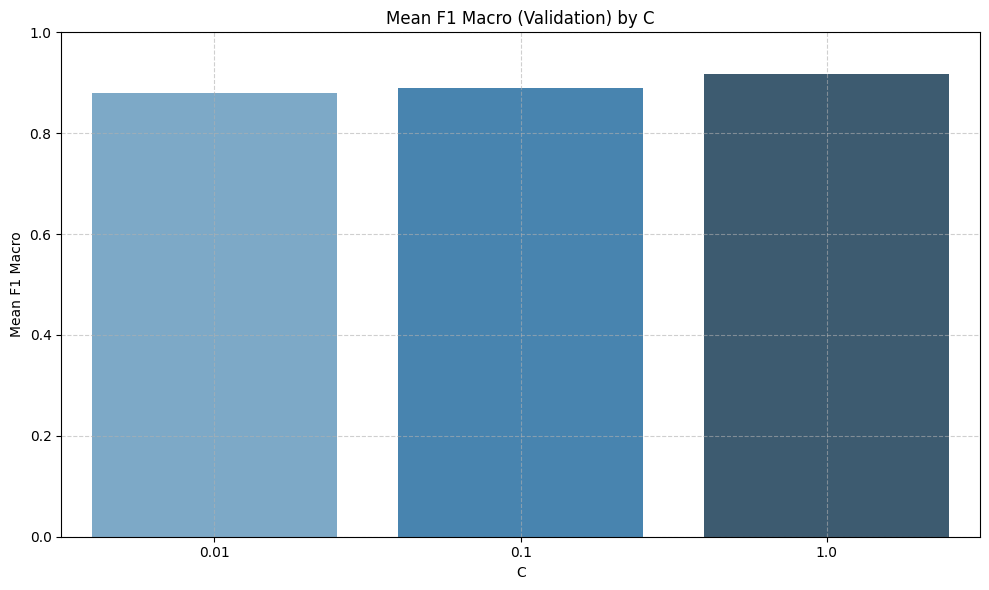

/tmp/ipython-input-23-3279836844.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


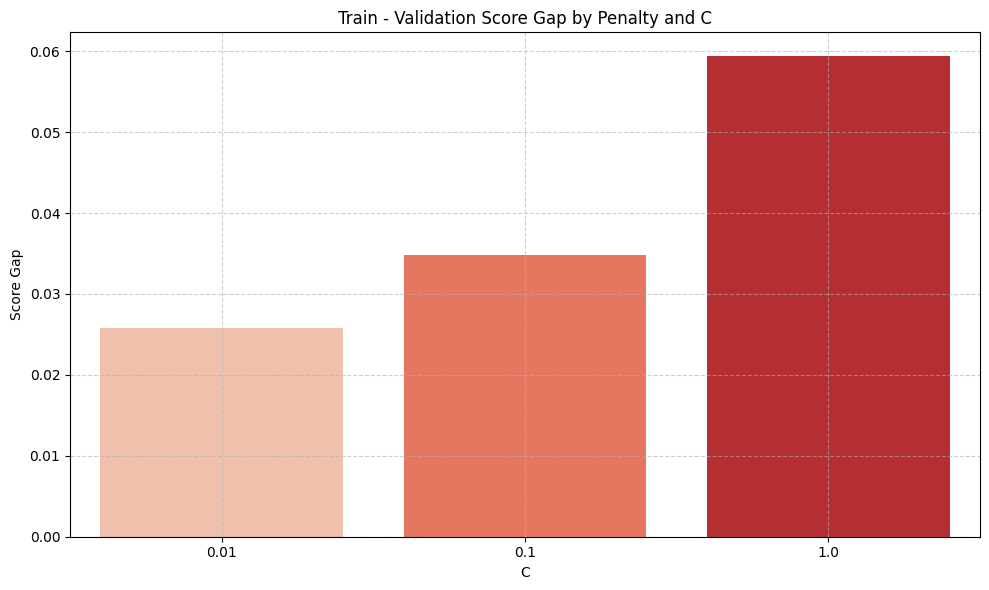

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

logreg = LogisticRegression(
    max_iter=3000,
    class_weight='balanced',
    random_state=42
)

param_grid = {
    'C': [0.01,0.1,1]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

grid.fit(X_train, y_train)

# 結果表示
import pandas as pd
df = pd.DataFrame(grid.cv_results_)
df_result = df[['param_C', 'mean_train_score', 'mean_test_score']].copy()
df_result['score_gap'] = df_result['mean_train_score'] - df_result['mean_test_score']
print(df_result.sort_values(by='mean_test_score', ascending=False))

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 検証F1スコア（Validation）
plt.figure(figsize=(10, 6))
sns.barplot(
    x='param_C',
    y='mean_test_score',
    data=df_result,
    palette='Blues_d'
)
plt.title('Mean F1 Macro (Validation) by C')
plt.xlabel('C')
plt.ylabel('Mean F1 Macro')
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Train–Validationギャップ
plt.figure(figsize=(10, 6))
sns.barplot(
    x='param_C',
    y='score_gap',
    data=df_result,
    palette='Reds'
)
plt.title('Train - Validation Score Gap by Penalty and C')
plt.xlabel('C')
plt.ylabel('Score Gap')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



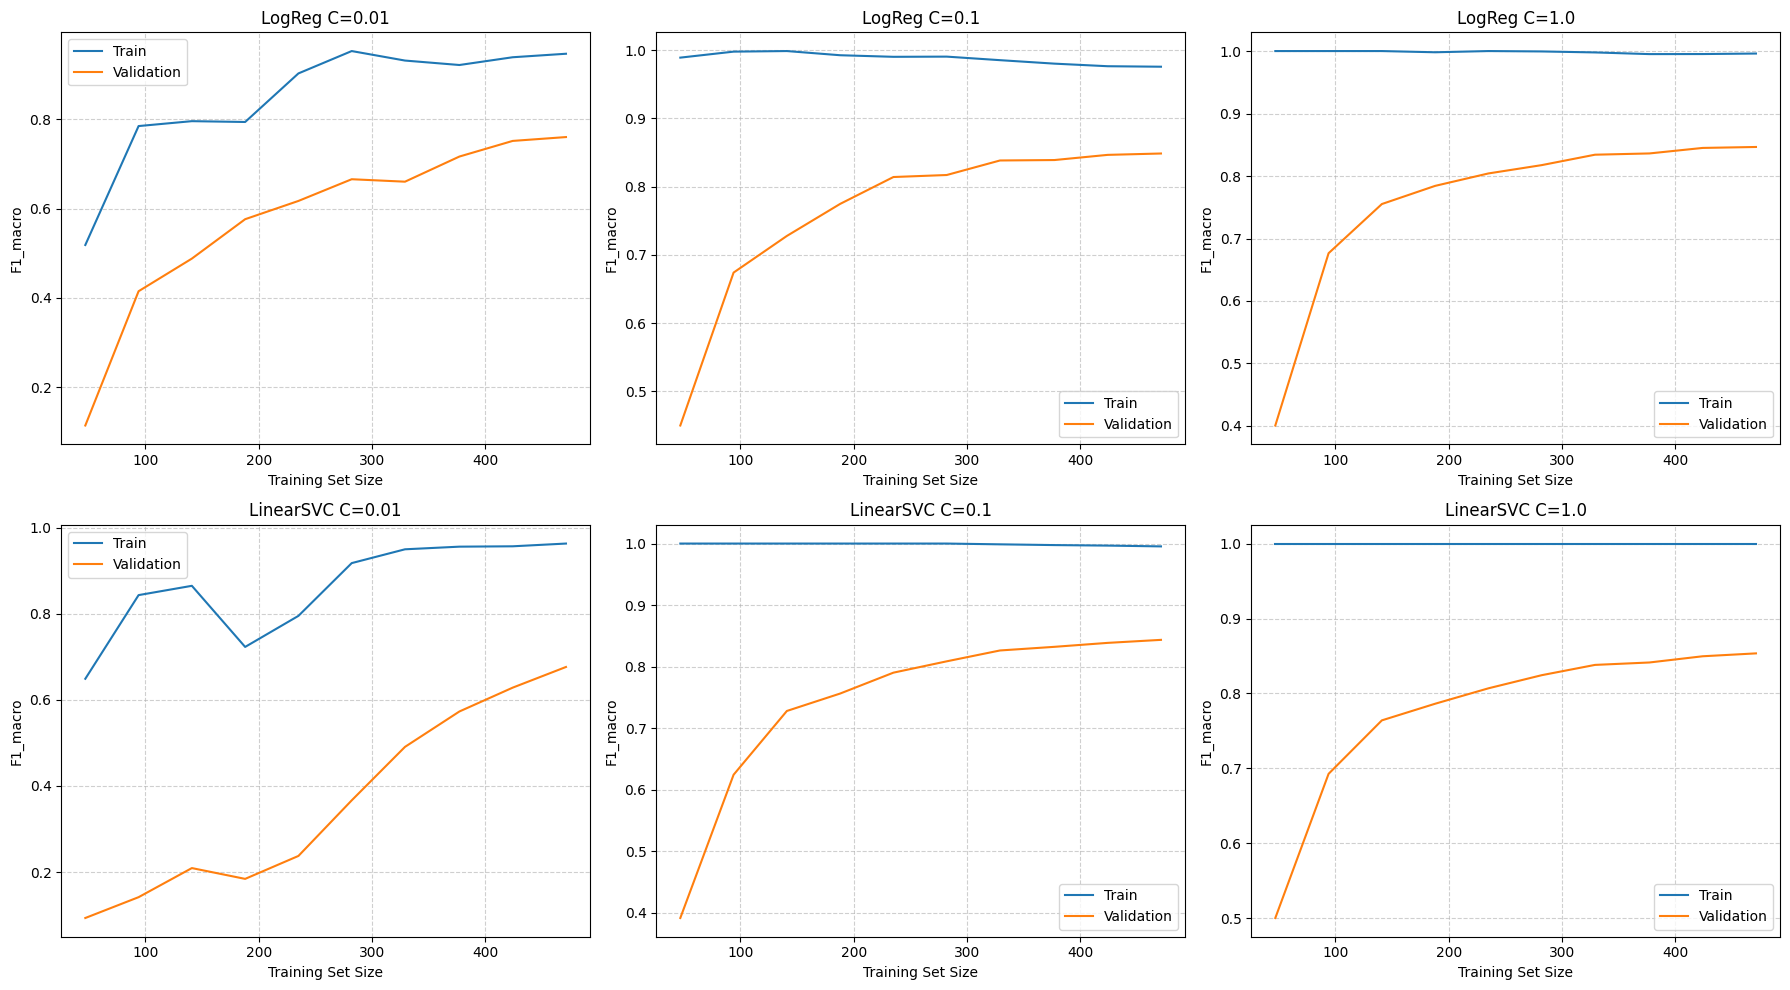

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Learning curve function
def plot_learning_curve(model, title, X, y, cv, scoring='f1_macro'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.01,0.1, 10),
        n_jobs=-1
    )
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring.capitalize())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

# GridSearch
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# モデル定義
Cs = [0.01, 0.1, 1.0]

logistic_models = [
    (f'LogReg C={C}', LogisticRegression(
        C=C,
        solver='saga',
        max_iter=3000,
        class_weight='balanced',
        random_state=42
    )) for C in Cs
]

svc_models = [
    (f'LinearSVC C={C}', LinearSVC(
        C=C,
        class_weight='balanced',
        max_iter=10000,
        random_state=42
    )) for C in Cs
]

# 描画
plt.figure(figsize=(18, 10))

# Logistic Regression (左列)
for idx, (name, model) in enumerate(logistic_models):
    plt.subplot(2, 3, idx + 1)        # 2行×3列レイアウト
    plot_learning_curve(model, name, X_train, y_train, cv)

# LinearSVM (右列)
for idx, (name, model) in enumerate(svc_models):
    plt.subplot(2, 3, idx + 4)        # 下段に配置
    plot_learning_curve(model, name, X_train, y_train, cv)

plt.tight_layout()
plt.show()


# 課題４ 改善結果

Logistic Regression と LinearSVC の2つのモデルについてハイパーパラメータc を変化させて性能を評価した。

* Logistic Regression 改善の結果と考察


Logistic Regression では C=1.0 のときに最も高い平均検証スコア（F1_macro = 0.917）を記録したが、trainスコアとの差（score_gap）が 0.059 とやや大きく、過学習の兆候が見られた。
一方、C=0.1 では精度はわずかに下がるものの、score_gap が小さく（0.035）、学習曲線でもtrainとvalidationのスコアが比較的収束しており、汎化性能の高いモデルと考えられる。
特に学習曲線からは、訓練データが少ない場合でも validation スコアが急速に上昇し、一定のデータ量でほぼ収束している点が確認でき、安定した学習が行えている。

* LinearSVC 改善の結果と考察


LinearSVC では C=10.0 において、最も高い F1_macro スコア（0.938）を記録した。ただし、trainスコアとの差は 0.062 と大きく、また他のすべてのC においても 訓練スコアが常にほぼ1.0 であることから、強い過学習の傾向が確認された。
学習曲線においても、trainスコアが一貫して高く、validationスコアとの差が大きい状態が続いており、モデルが訓練データに対して過度に適合している様子が見て取れる。

* 結論
汎化性能を重視するなら、**Logistic Regression（C=0.1）**が最適であり、バランスの取れたモデルといえる。

最大のF1スコアを狙う場合は、**LinearSVC（C=10.0）**が有力だが、過学習のリスクが高いため、最終的な未知データでの精度検証が必須である。

また、Logistic Regression は学習も高速で、扱いやすいという点で実用上のメリットが大きいと考えられる。

# 課題４ さらなる改善

hommeのrecall率改善

まずは、C値改善後のモデルを比較用に作成


LogReg_C1.0
Accuracy: 0.9403
              precision    recall  f1-score   support

 female-life      0.930     0.927     0.928       343
       homme      0.903     0.824     0.862       102
       kaden      0.926     0.936     0.931       173
 movie-enter      0.929     0.971     0.949       174
      sports      0.937     0.989     0.962       180
 tech-mobile      0.985     0.951     0.968       348
  topic-news      0.923     0.935     0.929       154

    accuracy                          0.940      1474
   macro avg      0.933     0.933     0.933      1474
weighted avg      0.941     0.940     0.940      1474


LinearSVC_C0.1
Accuracy: 0.9355
              precision    recall  f1-score   support

 female-life      0.920     0.933     0.926       343
       homme      0.936     0.716     0.811       102
       kaden      0.936     0.936     0.936       173
 movie-enter      0.934     0.971     0.952       174
      sports      0.927     0.989     0.957       180
 tech-mobile   

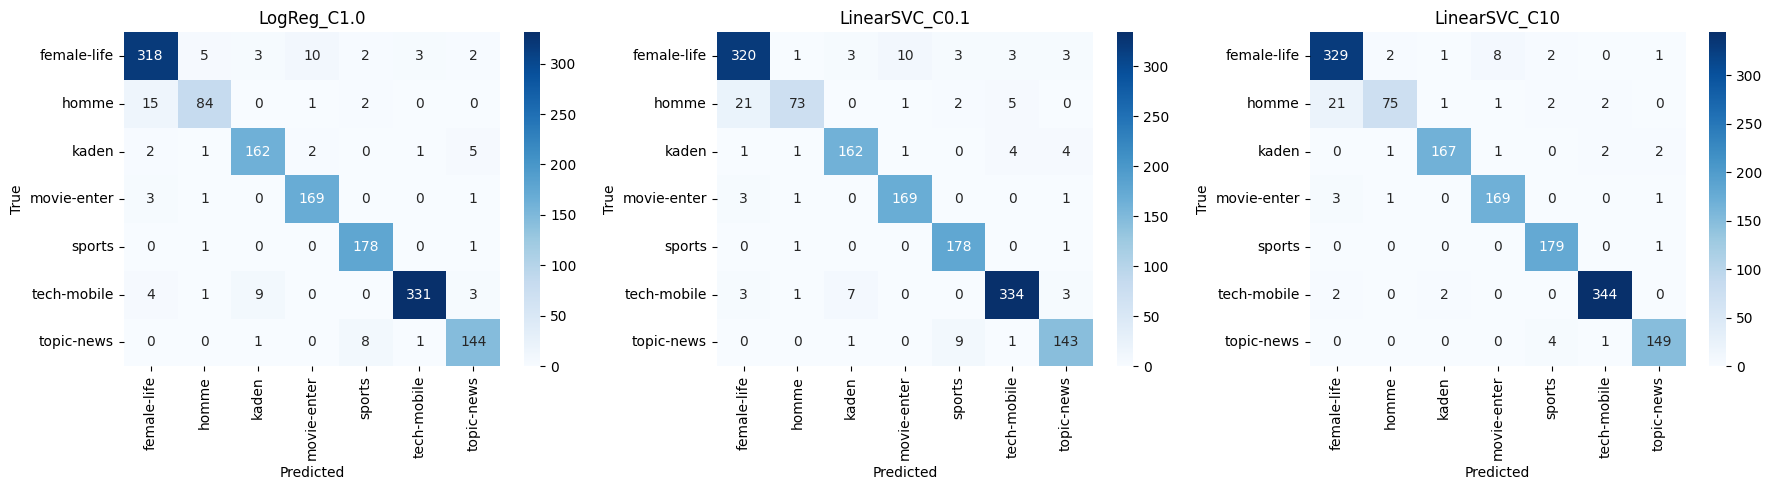

,Model,Accuracy,F1 Macro
0,LinearSVC_C10,0.957938,0.947137
1,LogReg_C1.0,0.940299,0.932787
2,LinearSVC_C0.1,0.935550,0.924220


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 改善後モデル
models = {
    "LogReg_C1.0": LogisticRegression(
        C=1.0, max_iter=1000, class_weight="balanced", random_state=42
    ),
    "LinearSVC_C0.1": LinearSVC(
        C=0.1, class_weight="balanced", max_iter=10000, random_state=42
    ),
    "LinearSVC_C10": LinearSVC(
        C=10, class_weight="balanced", max_iter=10000, random_state=42
    ),
}

results = []

fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

for (name, model), ax in zip(models.items(), axes):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 混同行列
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    sns.heatmap(
        cm,
        annot=True, fmt="d", cmap="Blues",
        xticklabels=model.classes_,
        yticklabels=model.classes_,
        ax=ax
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, digits=3)
    print(f"\n{name}\nAccuracy: {acc:.4f}\n{report}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Macro": (
            classification_report(y_test, y_pred, output_dict=True)
            ["macro avg"]["f1-score"]
        ),
    })

plt.tight_layout()
plt.show()

df_results = (
    pd.DataFrame(results)
    .sort_values("F1 Macro", ascending=False)
    .reset_index(drop=True)
)
display(df_results)

Hommeのrecall率**0.824～0.716**と、全モデルにおいてかなり低い

## Hommeのクラスを強調する　最終的に homme 2.5倍

最終的な class_weight: {'female-life': np.float64(0.614943128456642), 'homme': np.float64(5.145826056584003), 'kaden': np.float64(1.2183171387223486), 'movie-enter': np.float64(1.2095648604269293), 'sports': np.float64(1.1692460317460318), 'tech-mobile': np.float64(0.6047824302134647), 'topic-news': np.float64(1.3666512059369202)}

LogReg_C1.0
Accuracy: 0.9328
              precision    recall  f1-score   support

 female-life      0.951     0.904     0.927       343
       homme      0.746     0.892     0.812       102
       kaden      0.930     0.919     0.924       173
 movie-enter      0.933     0.960     0.946       174
      sports      0.941     0.972     0.956       180
 tech-mobile      0.985     0.945     0.965       348
  topic-news      0.923     0.935     0.929       154

    accuracy                          0.933      1474
   macro avg      0.916     0.932     0.923      1474
weighted avg      0.936     0.933     0.934      1474


LinearSVC_C0.1
Accuracy: 0.9389
           

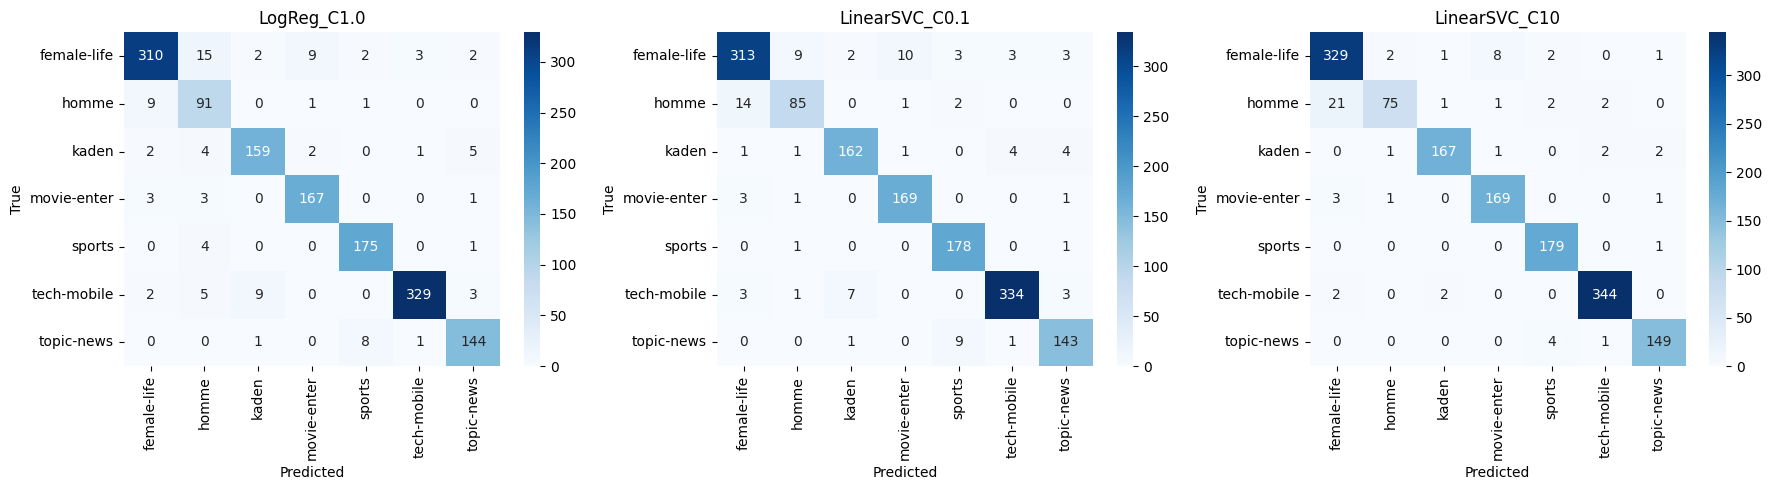

,Model,Accuracy,F1 Macro
0,LinearSVC_C10,0.957938,0.947137
1,LinearSVC_C0.1,0.938942,0.930940
2,LogReg_C1.0,0.932836,0.922854


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight   # 追加
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 1. class_weight を手動ブースト
#    - base: 'balanced'
#    - homme だけ 2.5 倍 - 手動調節の結果、最も3モデルの特徴が出た
classes = np.unique(y_train)
base_w = compute_class_weight('balanced', classes=classes, y=y_train)
w_dict = dict(zip(classes, base_w))
w_dict['homme'] *= 2.5    # 少数クラスを強調

print("最終的な class_weight:", w_dict)



# 2. 改善後モデル（class_weight に w_dict）
models = {
    "LogReg_C1.0": LogisticRegression(
        C=1.0, max_iter=1000, class_weight=w_dict, random_state=42
    ),
    "LinearSVC_C0.1": LinearSVC(
        C=0.1, class_weight=w_dict, max_iter=10000, random_state=42
    ),
    "LinearSVC_C10": LinearSVC(
        C=10, class_weight=w_dict, max_iter=10000, random_state=42
    ),
}



# 3. 学習 混同行列ヒートマップ 指標集計
results = []

fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

for (name, model), ax in zip(models.items(), axes):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=model.classes_, yticklabels=model.classes_, ax=ax
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, digits=3)
    print(f"\n{name}\nAccuracy: {acc:.4f}\n{report}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Macro": (
            classification_report(y_test, y_pred, output_dict=True)
            ["macro avg"]["f1-score"]
        ),
    })

plt.tight_layout()
plt.show()


# 4. 結果 DataFrame

df_results = (
    pd.DataFrame(results)
    .sort_values("F1 Macro", ascending=False)
    .reset_index(drop=True)
)
display(df_results)



* Before-After

| モデル                 | **Accuracy**        | **F1‑macro**        | **homme Recall**    | 変化のざっくり評価                                            |
| ------------------- | ------------------- | ------------------- | ------------------- | ---------------------------------------------------- |
| **LogReg C=1.0**    | **↓ 0.940 → 0.933** | **↓ 0.933 → 0.923** | **↑ 0.824 → 0.892** | *homme* は大幅改善だが、他クラスで Precision/Recall が落ちて全体指標はマイナス |
| **LinearSVC C=0.1** | **↑ 0.936 → 0.939** | **↑ 0.924 → 0.931** | **↑ 0.716 → 0.833** | “全体も*homme* も両取り”――大幅に改善                           |
| **LinearSVC C=10**  | **＝ 0.958 → 0.958** | **＝ 0.947 → 0.947** | **＝ 0.735 → 0.735** | 高 C では重みがほぼ効かず、スコア変わらず                               |


* Weight後の各モデルに対する所感

| モデル                         | 長所                                            | 短所                          | 用途                        |
| --------------------------- | ----------------------------------------------- | ------------------------------ | ----------------------------- |
| **LogReg (C=1, 重み2.5×)**      | *homme* を 90 % 近く拾える                            | Accurac,macroF1が最低| 少数クラス検知が最優先。多少ほかが落ちても良い     |
| **LinearSVC (C=0.1, 重み2.5×)** | *homme* Recall 0.83 (+0.12) なのに macroF1 +0.7 pt | 総合性能が C=10 に劣る               | 全体バランスを保ちつつ *homme* を底上げ    |
| **LinearSVC (C=10, 重み2.5×)**  |  Accuracy 0.958                            | 少数クラスは未改善                      | 最高精度が絶対条件　誤検知＜見逃し |
